## self-sustainable Save a custom PyTorch Model

[tutorial] https://huggingface.co/docs/transformers/en/custom_models

In [1]:
from transformers import AutoModel
from model import AudioMAEConfig, PretrainedAudioMAEEncoder

C:\Users\dslee\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Registering a model with custom code to the auto classes

# AutoConfig.register("audiomae", AudioMAEConfig)  # doesn't seem needed; redundant with the one below.
# AutoModel.register(AudioMAEConfig, PretrainedAudioMAEEncoder)  # doesn't seem needed; redundant with the one below.
AudioMAEConfig.register_for_auto_class()
PretrainedAudioMAEEncoder.register_for_auto_class()

In [3]:
# create instances
config = AudioMAEConfig()
model = PretrainedAudioMAEEncoder(config)

In [4]:
# # load pretrained model and get the pretrained weights
# pretrained_model = timm.create_model("hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m", pretrained=True)
# pretrained_model = pretrained_model.eval()
# pretrained_state_dict = pretrained_model.state_dict()

# # update the key names
# new_keys = []
# for k in pretrained_state_dict.keys():
#     new_keys.append('encoder.' + k)
# pretrained_state_dict = {new_keys[i]: v for i, (k, v) in enumerate(pretrained_state_dict.items())}

c:\Users\dslee\anaconda3\envs\sound_effect_variation_generation\lib\site-packages\timm\models\_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(ca

In [4]:
# load the uploaded model
pretrained_model = AutoModel.from_pretrained("hance-ai/audiomae", trust_remote_code=True)
pretrained_state_dict = pretrained_model.state_dict()

c:\Users\dslee\anaconda3\envs\sound_effect_variation_generation\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dslee\.cache\huggingface\hub\models--hance-ai--audiomae. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
A new version of the following files was downloaded from https://huggingface.co/han

In [6]:
# load the pretrained weights
model.load_state_dict(pretrained_state_dict)

<All keys matched successfully>

In [6]:
with open('token.txt', 'r') as file:
    token = file.read().strip()

model.push_to_hub('hance-ai/audiomae', token=token)  # put your token

c:\Users\dslee\anaconda3\envs\sound_effect_variation_generation\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dslee\.cache\huggingface\hub\models--hance-ai--audiomae. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/hance-ai/audiomae/commit/8694643200b74c48bfa6570fa1678d13b5ae40b1', commit_message='Upload PretrainedAudioMAEEncoder', commit_description='', oid='8694643200b74c48bfa6570fa1678d13b5ae40b1', pr_url=None, pr_revision=None, pr_num=None)

Recommend git fetching and pulling so that the uploaded model is synced locally too.

***

In [1]:
from transformers import AutoModel

# load the uploaded model
model = AutoModel.from_pretrained("hance-ai/audiomae", trust_remote_code=True)

C:\Users\dslee\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# forward
z = model('.sample_sound/baby_coughing.wav')
print('z.shape:', z.shape)

z.shape: torch.Size([768, 8, 64])


### Sanity check

In [4]:
from sklearn.decomposition import PCA
import numpy as np
from einops import rearrange

def reduce_dimension(z_ssl):
    d, h, w = z_ssl.shape
    
    z_ssl = rearrange(z_ssl, 'd h w -> (h w) d')
    pca = PCA(n_components=8)
    z_ssl_pca = pca.fit_transform(z_ssl)
    z_ssl_pca = rearrange(z_ssl_pca, '(h w) d -> d h w', h=h, w=w)
    return z_ssl_pca, pca.explained_variance_ratio_

z_ssl_pca, explained_variance_ratio = reduce_dimension(z.detach().numpy())  # (d h w)
n_pca_components = z_ssl_pca.shape[0]
print('z_ssl_pca.shape:', z_ssl_pca.shape)
print('explained_variance_ratio:', np.around(explained_variance_ratio, 2))

z_ssl_pca.shape: (8, 8, 64)
explained_variance_ratio: [0.1  0.07 0.07 0.05 0.04 0.03 0.03 0.02]


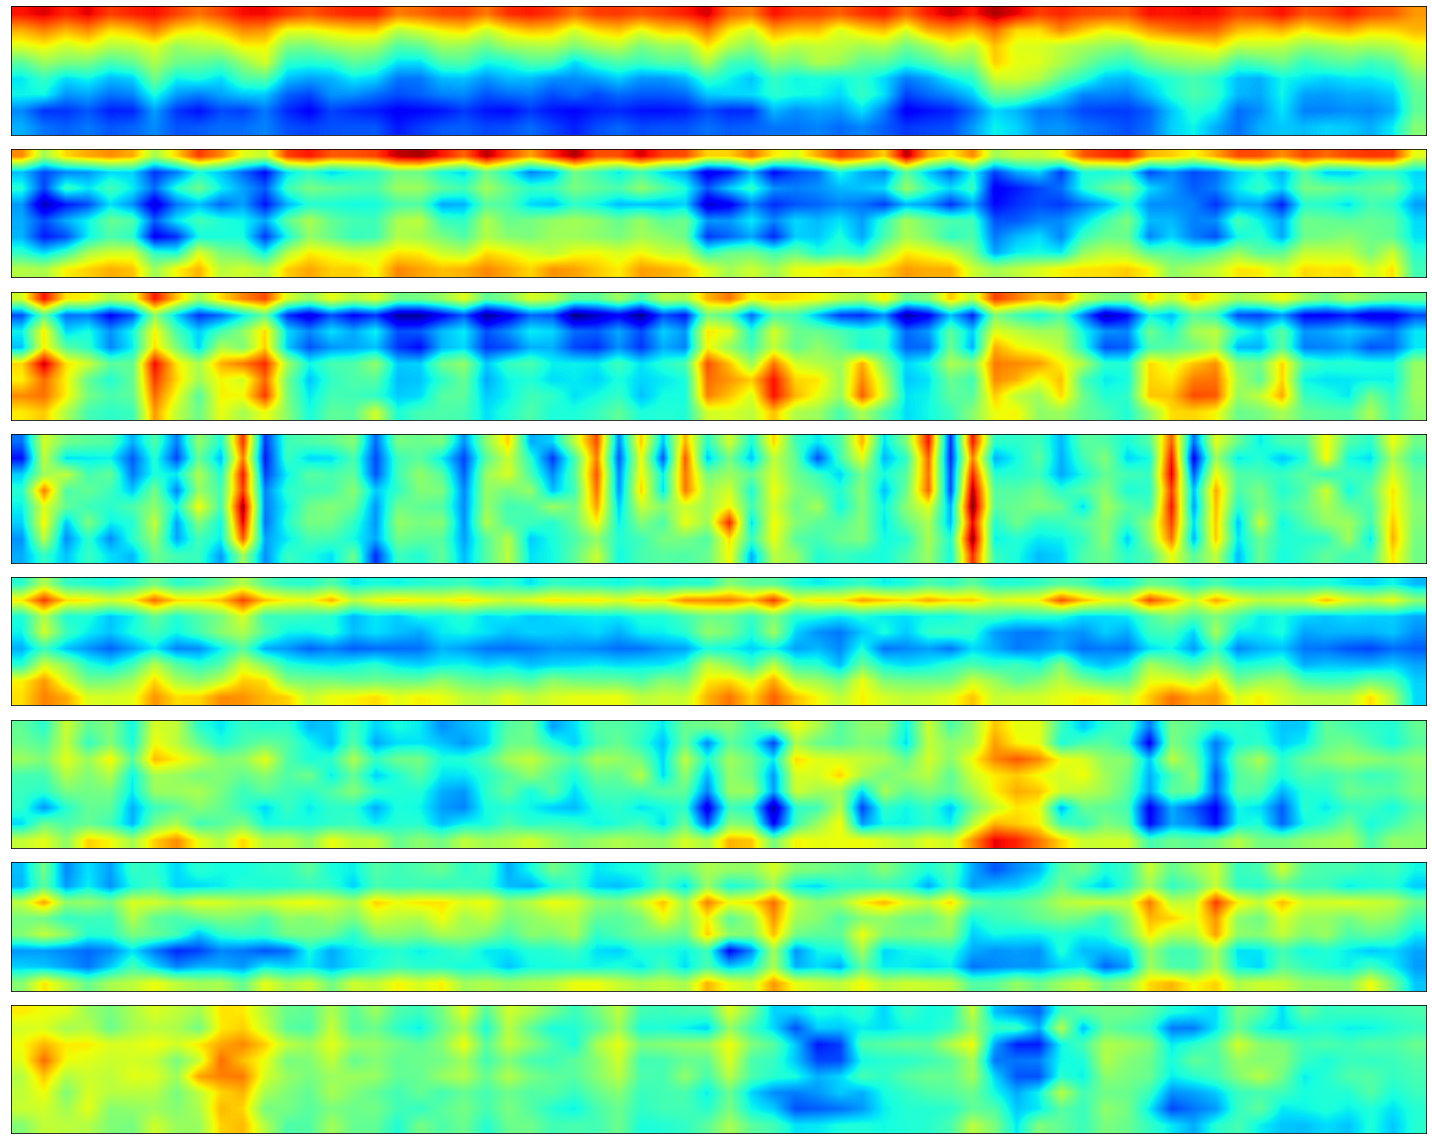

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(n_pca_components, 1, figsize=(20, 2*n_pca_components))
for c, ax in enumerate(axes):
    # ax.set_title(f'pca channel idx:{c}', fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(z_ssl_pca[c], cmap='jet', aspect='auto', interpolation='bilinear', 
              vmin=z_ssl_pca.min(), vmax=z_ssl_pca.max(),
              )
    ax.invert_yaxis()
plt.tight_layout()
plt.show()